# Dimensionality reduction

In [54]:
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('grade3')

## 1. Dataset

Let's use data from the 2015 Finnish parliamentary elections, which is available at [avoindata.fi website](https://www.avoindata.fi/data/fi/dataset/eduskuntavaalien-2015-ylen-vaalikoneen-vastaukset-ja-ehdokkaiden-taustatiedot). The dataset contains the election candidates' answers to the Yle's (Finnish Broadcasting Company) voting advice application (_vaalikone_ in Finnish).

### 1.1 Load the data

In [35]:
import os
import pandas as pd

df = pd.read_csv(os.path.join("data", "vastauksetavoimenadatana1.csv"),
                 sep=";", encoding="utf-8")
# Extract the names of the parties for later use before dropping the column
party_name = df.puolue
# Show the first few rows of the dataset
df.head(3)

,vaalipiiri,id,sukunimi,etunimi,puolue,ikä,sukupuoli,Toimin tällä hetkellä kansanedustajana.,vastattu,sitoutumaton,...,239|Jokeri-kysymys: Vaalilupauksista täytyy pitää kiinni.,239|kommentti,240|Jokeri-kysymys: Vaalilupauksista täytyy pitää kiinni.,240|kommentti,241|Jokeri-kysymys: Vaalilupauksista täytyy pitää kiinni.,241|kommentti,242|Jokeri-kysymys: Vaalilupauksista täytyy pitää kiinni.,242|kommentti,243|Jokeri-kysymys: Vaalilupauksista täytyy pitää kiinni.,243|kommentti
0,08 Kaakkois-Suomen vaalipiiri,4844,Aalto,Airi,Perussuomalaiset,57,F,0,7.3.2015 19:35,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12 Oulun vaalipiiri,5750,Aalto,Esa,Vihreä liitto,32,M,0,14.3.2015 17:36,0,...,NaN,NaN,NaN,NaN,NaN,NaN,täysin samaa mieltä,Miksi sitten luvata?,NaN,NaN
2,07 Pirkanmaan vaalipiiri,5535,Aalto,Harri,Vasemmistoliitto,57,M,0,8.3.2015 20:56,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The data contains both personal details of the candidates as well as answers to the questions. The possible answers for categorical questions are the following (shown programmatically below in Finnish):
* somewhat agree
* somewhat disagree
* completely disagree
* completely agree
* skip question

In [34]:
df["127|Suomessa on liian helppo elää sosiaaliturvan varassa"].dropna().unique().tolist()

['jokseenkin samaa mieltä',
 'jokseenkin eri mieltä',
 'täysin eri mieltä',
 'täysin samaa mieltä',
 'ohita kysymys']

### 1.2 Define the metadata
Next, let's define the main parties in the dataset along with a different color and marker for each party.

In [53]:
from collections import namedtuple

Party = namedtuple(typename="Party", field_names=["name", "color", "marker"])
PARTIES = [Party("Suomen Keskusta", "#00663E", "^"),
           Party("Suomen Sosialidemokraattinen Puolue", "#E11933", "s"),
           Party("Kansallinen Kokoomus", "#003A54", "*"),
           Party("Vasemmistoliitto", "#BF1D23", "_"),
           Party("Perussuomalaiset", "#15569C", "|"),
           Party("Vihreä liitto", "#5FBE18", "D"),
           Party("Suomen Kristillisdemokraatit", "#1574C4", "v"),
           Party("Itsenäisyyspuolue", "#F3811F", "x"),
           Party("Piraattipuolue", "#512483", ">"),
           Party("Suomen ruotsalainen kansanpuolue", "#017AC9", "o")]
PARTY_COLORS = dict([[p.name, p.color] for p in PARTIES])
PARTY_MARKERS = dict([[p.name, p.marker] for p in PARTIES])

### 1.3 Pre-process the data

As pre-processing steps, let's throw away all the other variables except the answers to the nationwide categorical questions to see if the visualization of the dimensionality reduction can give us a hint of the possibility of being able to deduce the party of an unknown candidate based on only his/her answers. We shall also keep only the candidates from the parties defined in the metadata. Lastly, all the variables are one-hot encoded because the answers are categorical and not ordinal because of the "skip question" option.


In [36]:
# Check out this plot to determine the location specific questions,
# which contain considerably more missing values than the other variables.
# df.isna().sum().plot.line()

nationwide_categorical_questions = [
    # Categorical questions
    c for c in df.columns if c[0].isdigit() and not c.endswith("kommentti") and
    # Columns with a lot of NaNs are location-specific questions
    df[c].isna().sum() <= 1500]

df = df.loc[
    # Keep only people from the main parties
    df.puolue.isin([p.name for p in PARTIES]),
    # Keep only relevant columns
    nationwide_categorical_questions]

# One-hot encode
df = pd.get_dummies(df)


def drop_constant_columns_rows(df):
    df = df.loc[:, df.var(axis=0) > 0]
    df = df.loc[df.var(axis=1) > 0, :]
    return df


df = drop_constant_columns_rows(df)
party_name = party_name.loc[df.index]

## 2. Results 
### 2.1 Uniform Manifold Approximation and Projection (UMAP)

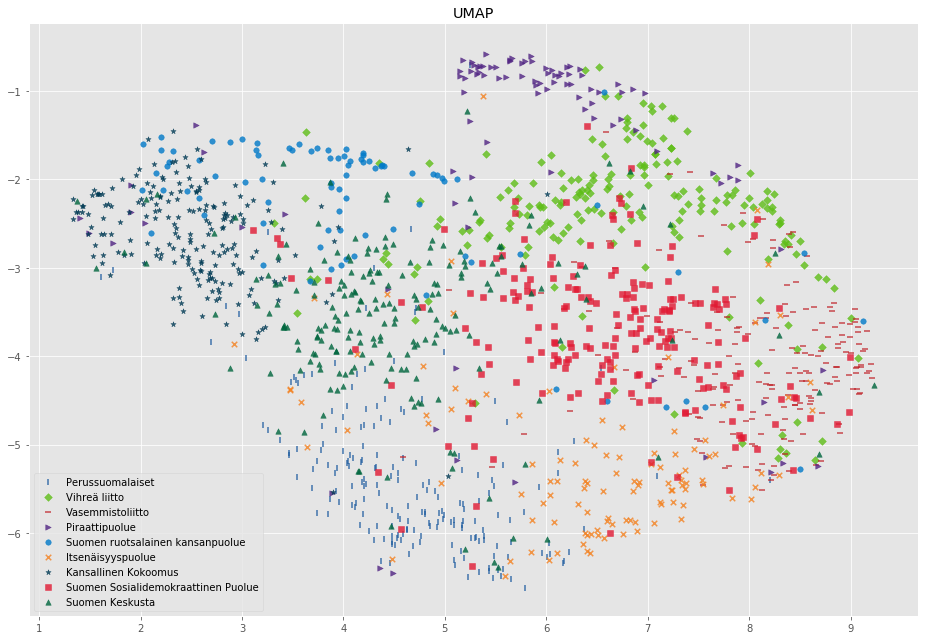

In [51]:
import umap
import matplotlib.pyplot as plt
plt.style.use("ggplot")

metric = "hamming"
embedding = umap.UMAP(n_neighbors=20,
                      min_dist=0.1,
                      metric=metric).fit_transform(df)

ax = plt.figure(figsize=(13, 9)).add_subplot(111)
for p in party_name.unique():
    ax.scatter(x=embedding[party_name == p, 0],
               y=embedding[party_name == p, 1],
               s=30, alpha=0.8,
               c=PARTY_COLORS[p],
               marker=PARTY_MARKERS[p],
               label=p)
plt.title("UMAP")
plt.tight_layout()
plt.legend();

### 2.2 T-distributed Stochastic Neighbor Embedding (t-SNE)

In [52]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', random_state=0)
embedding = tsne.fit_transform(df)

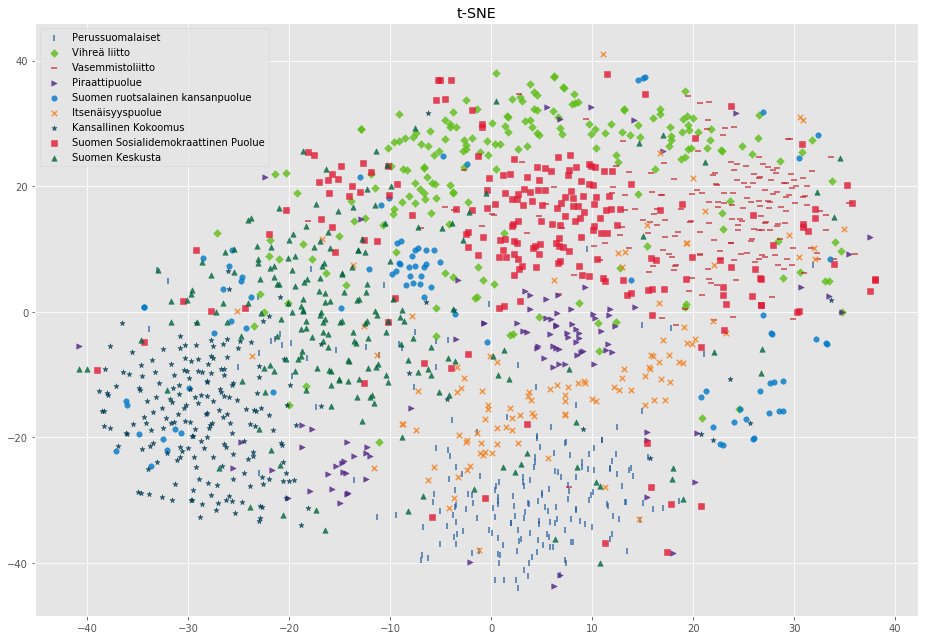

In [17]:
ax = plt.figure(figsize=(13, 9)).add_subplot(111)
for p in party_name.unique():
    ax.scatter(x=embedding[party_name == p, 0],
               y=embedding[party_name == p, 1],
               s=30, alpha=0.8,
               c=PARTY_COLORS[p],
               marker=PARTY_MARKERS[p],
               label=p)
plt.title("t-SNE")
plt.tight_layout()
plt.legend();

### 2.3 Principal Component Analysis (PCA)

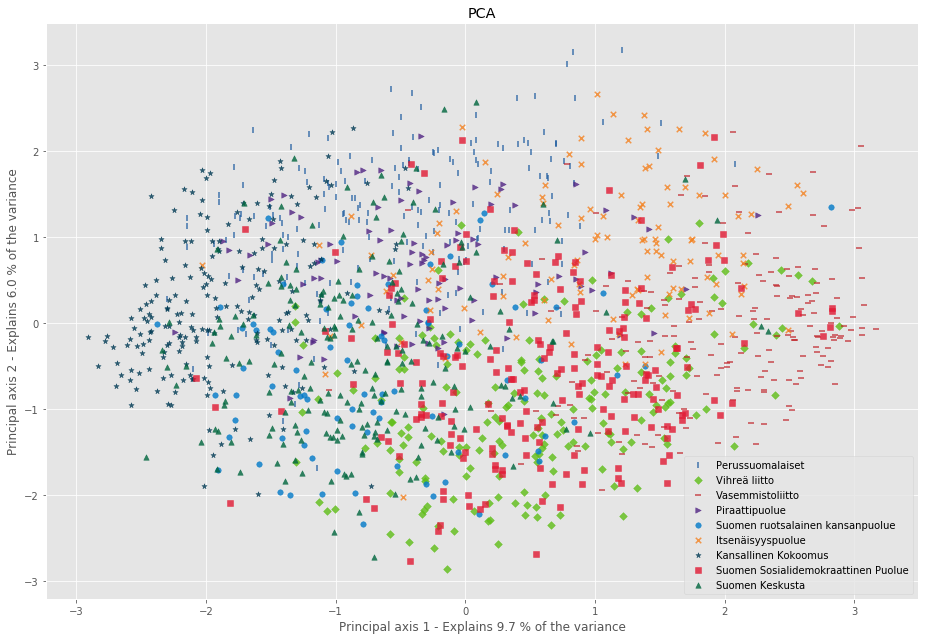

In [55]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embedding = pca.fit_transform(df)

ax = plt.figure(figsize=(13, 9)).add_subplot(111)
for p in party_name.unique():
    ax.scatter(x=embedding[party_name == p, 0],
               y=embedding[party_name == p, 1],
               s=30, alpha=0.8,
               c=PARTY_COLORS[p],
               marker=PARTY_MARKERS[p],
               label=p)
plt.title("PCA")
plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
    pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
    pca.explained_variance_ratio_[1] * 100.0))
plt.tight_layout()
plt.legend();

## 3. Conclusions

